# Think Bayes - Chapter 8

Following A. B. Downey's book *Think Bayes*, but using Julia as opposed to Python

In [135]:
using Statistics, Distributions, Plots, Printf, Distributed

## World cup problem

In the 2018 FIFA World Cup final, France defeated Croatia 4 goals to 2. Based on this outcome:

1. How confident should we be that France is a better team?
2. If the same game would be played again, that France would win again?

Model the probability of each team scoring $k$ goals in time period $0\dots t$ as a Poisson process:

$$
g\left(k,\,t\right)=\frac{\left(\lambda t\right)^k}{k!} \exp\left(-\lambda t\right)
$$

So the question reduces to which team has a higher scoring rate $\lambda$

### Modelling goals

Plot Poisson distribution

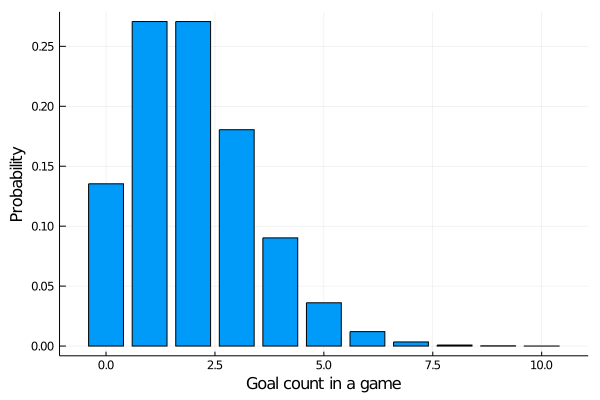

In [14]:
score_rate_per_min = 2 / 90 # 2 goals per game
duration_min = 90

goal_count_arr = Vector(0:10)
prob_arr = pdf.(Poisson(score_rate_per_min * duration_min), goal_count_arr)

bar(
    goal_count_arr,
    prob_arr,
    xlabel="Goal count in a game",
    ylabel="Probability",
    label=false
)

### Modelling scoring rates

Scoring rates will be modelled by $\Gamma$-distribution:

$$
f\left(x\right)=\frac{1}{\Gamma\left(k\right)\theta^k}\,x^{k-1}\exp\left(-x/\theta\right)
$$

Mean at $k\theta$ and variance at $k\theta^2$. With *shape parameter* $k$ and *scale parameter* $\theta$

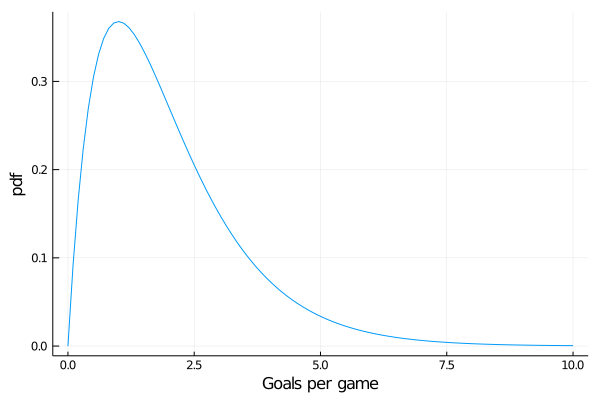

In [31]:
shape_param = 2
scale_param = 1

score_rate_per_game_arr = Array(LinRange(0, 10, 100))
pdf_score_rate_arr = pdf.(Gamma(shape_param, scale_param), score_rate_per_game_arr)

plot(
    score_rate_per_game_arr,
    pdf_score_rate_arr,
    xlabel="Goals per game",
    ylabel="pdf",
    label=false
)

## Update: obtaining posterior goal rate distributions

We start off with the same beliefs for France's and Croatia's goal rates, and then update them according to the number of observed goals.

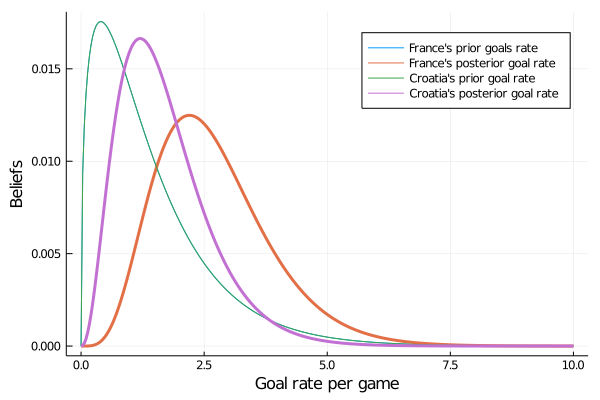

In [139]:
function goal_rate_update(
    goal_rate_arr::Vector{Float64},
    goal_rate_prior_arr::Vector{Float64},
    goals_per_game_count::Int64
    #
)::Vector{Float64}
    """
    Given the prior probability distribution for the goal rate, and the 
    current goal count per game update the prior assuming the likelihood
    given by Posson distibution
    
    Arguments:
    ----------
        * goal_rate_arr: goal rates (per game) for which the priors are given
        * goal_rate_prior_arr: the prior beliefs for the goal rates
        * goals_per_game_count: number of goals in the current game
    """
    
    # compute likelihood
    lkhd_given_rate_arr = broadcast(
        lam->pdf(Poisson(lam), goals_per_game_count),
        goal_rate_arr
    )
    
    # compute posterior
    goal_rate_prior_arr = lkhd_given_rate_arr .* goal_rate_prior_arr
    
    # normalize
    goal_rate_prior_arr = goal_rate_prior_arr / sum(goal_rate_prior_arr)
    
    return goal_rate_prior_arr
end

###

# set up priors
goal_rate_arr = Vector(LinRange(0, 10, 300))
#
france_prior_goal_rate_arr = pdf.(Gamma(1.4), goal_rate_arr)
france_prior_goal_rate_arr = france_prior_goal_rate_arr / sum(france_prior_goal_rate_arr)
#
croatia_prior_goal_rate_arr = pdf.(Gamma(1.4), goal_rate_arr)
croatia_prior_goal_rate_arr = croatia_prior_goal_rate_arr / sum(croatia_prior_goal_rate_arr)

# get posteriors
# france - 4 goals
france_post_goal_rate_arr = goal_rate_update(
    goal_rate_arr,
    france_prior_goal_rate_arr,
    4
)
# croatia - 2 goals
croatia_post_goal_rate_arr = goal_rate_update(
    goal_rate_arr,
    croatia_prior_goal_rate_arr,
    2
)

####

plot(
    goal_rate_arr,
    france_prior_goal_rate_arr,
    label="France's prior goals rate",
    xlabel="Goal rate per game",
    ylabel="Beliefs"
)
#
plot!(
    goal_rate_arr,
    france_post_goal_rate_arr,
    label="France's posterior goal rate",
    linewidth=3
)
#
plot!(
    goal_rate_arr,
    croatia_prior_goal_rate_arr,
    label="Croatia's prior goal rate"
)
#
plot!(
    goal_rate_arr,
    croatia_post_goal_rate_arr,
    label="Croatia's posterior goal rate",
    linewidth=3
)

## Is France a better team?

What is the probability that France is a better team? This is the probability that France's goal rate is higher. So we want to count cases where $P[\lambda_{France}>\lambda_{Croatia}]$

In [140]:
prob_france_better = 0.0

# the posteriors have already been normalized as probabilities 
# so should not need to do any further normalization here
for (fgr, fpost) in zip(goal_rate_arr, france_post_goal_rate_arr)
    for (cgr, cpost) in zip(goal_rate_arr, croatia_post_goal_rate_arr)
        if fgr > cgr
            # add probability of this specific configurations
            prob_france_better += fpost * cpost
        end
    end
end

@printf("Probability of France being the better team is %.1f%%", 100*prob_france_better)

Probability of France being the better team is 75.8%

## Probability of France winning again

The probability of France winning for any specific combination of goal rates:

$$
P[F \,\mbox{beats}\, C]=\sum_{k=0}^{N} P_F[k] \sum_{k'=0}^{k-1} P_C[k']=\exp\left(-\left(\lambda_F+\lambda_C\right)\,t\right) \sum_{k=0}^{N} \frac{\left(\lambda_F t\right)^k}{k!} \sum_{k'=0}^{k-1} \frac{\left(\lambda_C t\right)^{k'}}{k'!}
$$

In [127]:
function prob_first_team_wins(
    first_team_goal_rate::Float64,
    second_team_goal_rate::Float64,
    max_goal_count::Int=20
)::Float64
    """
    Calculate the probability that the first team
    beats the second team given the goal rates.
    
    Simply go over all possible combinations of goals that will
    allow the first team to win, and add up the probabilities
    
    Note that draws are not counted
    
    Arguments:
    ----------
        * first_team_goal_rate - goal rate, per game, of the first team
        * second_team_goal_rate - goal rate of the second tam
        * max_goal_count - maximum number of goals to consider
    
    Returns:
    --------
        Probability of the first team winning
    """
    
    prob_fw = 0.0
    
    # go through all possible goal counts of the first team
    # and then the second team
    for i_ft_goal in 1:1:max_goal_count
        cur_prefac = (first_team_goal_rate)^i_ft_goal / factorial(i_ft_goal)
        
        for i_st_goal in 0:1:(i_ft_goal-1)
            cur_fullfac = cur_prefac * ((second_team_goal_rate)^i_st_goal) / factorial(i_st_goal)
            
            prob_fw += cur_fullfac
        end
    end
    
    # normalize
    prob_fw *= exp(-(first_team_goal_rate + second_team_goal_rate))
    
    
    return prob_fw
end

prob_first_team_wins (generic function with 2 methods)

So the probability of the first team winning, given the goal rates, is

In [128]:
prob_first_team_wins(
    5.0,
    0.8
)

0.9500786400873267

Now apply this to goal rate distributions and average over the beliefs for the goal rates to extract the weighed probability.

In [141]:
france_winning_prob = 0.0

for (fgr, fpost) in zip(goal_rate_arr, france_post_goal_rate_arr)
    for (cgr, cpost) in zip(goal_rate_arr, croatia_post_goal_rate_arr)
        
        # calculate the probability of winning and 
        # scale it by probability of the goal rates
        f_wins_prob = prob_first_team_wins(fgr, cgr)
        france_winning_prob += f_wins_prob * fpost * cpost
        
    end
end

@printf("Probability of France winning again is %.1f %%", 100 * france_winning_prob)

Probability of France winning again is 57.1 %